<a href="https://colab.research.google.com/github/chaezz/django-firstweb/blob/master/2021_05_06_PM_Neural_Network_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

미세먼지 베이스라인을 만들기 위해 Neural_Network(NN)방식을 사용하려 한다.
베이스라인은 기상 데이터(풍속, 습도, 강우량, 시간, 년중날짜)만을 이용해 미세먼지 PM2.5, PM10을 예측한다.

우선 pm2.5만 확인한다.

In [36]:
from keras.models import Sequential
from keras.layers import Dense
# first neural network with keras make predictions
# from numpy import loadtxt

import datetime
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.4.1


### 데이터 불러오기
기상청과 에어코리아에서 2019, 2020년도의 데이터를 불러온다.
각 컬럼은 다음을 의미한다.
- time : 시간
- temp : 기온
- ws : 풍속
- hd : 습도
- pp : 강수량
- pm2.5 : 미세먼지PM2.5
- pm10 : 미세먼지PM10



In [109]:
dataset = pd.read_csv('kma_pm_2019.csv')
dataset['time'] = dataset['time'].apply(lambda x: pd.to_datetime(str(x), format='%Y-%m-%d %H:%M'))
print(dataset.head(10))
print(dataset.shape)
print(dataset.dtypes)



                 time  temp   ws  hd  pp   wd  pm25  pm10
0 2019-01-01 00:00:00  -4.9  0.4  62 NaN    0   4.0  16.0
1 2019-01-01 01:00:00  -4.4  0.6  61 NaN   90  40.0  55.0
2 2019-01-01 02:00:00  -3.9  0.4  59 NaN    0  50.0  65.0
3 2019-01-01 03:00:00  -4.4  1.0  61 NaN  200  39.0  73.0
4 2019-01-01 04:00:00  -5.1  0.7  66 NaN  320  46.0  60.0
5 2019-01-01 05:00:00  -5.5  0.0  68 NaN    0  49.0  53.0
6 2019-01-01 06:00:00  -5.3  0.4  70 NaN    0  35.0  59.0
7 2019-01-01 07:00:00  -5.6  0.7  73 NaN  110  42.0  52.0
8 2019-01-01 08:00:00  -6.1  1.2  76 NaN  320  36.0  51.0
9 2019-01-01 09:00:00  -4.9  0.8  74 NaN  320  32.0  43.0
(8760, 8)
time    datetime64[ns]
temp           float64
ws             float64
hd               int64
pp             float64
wd               int64
pm25           float64
pm10           float64
dtype: object


결측치를 조회해본다.
조회결과 강수량이 결측치가 제일 많다.

In [110]:
print(dataset.isna().sum(0))

time       0
temp       0
ws         0
hd         0
pp      7964
wd         0
pm25     556
pm10     480
dtype: int64


# 시간 변환
날씨 데이터는 일일 및 연간 주기성이 명확하다.<br> 특히 미세먼지는 날씨, 시간대에 민감한 영향을 미치기 때문에 시간 및 연중 시간 신호로 변환해줘야 한다.

In [91]:
date_time = pd.to_datetime(dataset.pop('time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [92]:
day = 24*60*60
year = (365.2425)*day

dataset['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
dataset['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
dataset['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
dataset['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

필요한 데이터들만 추출한다.(강수량은 결측치가 많아서 제거)

In [93]:
col = ['temp','ws','hd','wd','pm25', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
dataset = dataset[col]

dataset에서 결측치르 제거해준다.(미세먼지 결측치 제거)

In [94]:
dataset = dataset.dropna()

train_set과 test_set를 8:2 비율로 나눈다.

In [95]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [96]:
train_dataset

,temp,ws,hd,wd,pm25,Day sin,Day cos,Year sin,Year cos
533,-1.0,0.8,87,90,35.0,0.965926,2.588190e-01,0.374694,0.927149
3065,20.5,2.1,28,200,17.0,-0.965926,-2.588190e-01,0.809108,-0.587659
4501,28.7,4.4,48,50,9.0,-0.258819,-9.659258e-01,-0.086558,-0.996247
1554,11.7,1.7,52,360,112.0,-1.000000,4.518706e-13,0.898307,0.439368
2036,14.3,1.5,52,200,27.0,-0.866025,5.000000e-01,0.994021,0.109188
...,...,...,...,...,...,...,...,...,...
1895,10.5,1.1,97,340,14.0,-0.258819,9.659258e-01,0.977932,0.208922
2674,19.7,1.0,66,200,44.0,0.500000,-8.660254e-01,0.940090,-0.340925
821,-1.0,1.1,64,270,37.0,0.965926,2.588190e-01,0.556776,0.830663
2275,14.2,2.5,31,200,33.0,-0.965926,2.588190e-01,0.998085,-0.061865


### 데이터 정규화
각 특성별 스케일의 범위가 다르기 때문에 정규화 작업을 해줘야한다.<br>
먼저 데이터 정규화를 위해 통계적 자료를 준비하고, label(예측값)인 "pm25"를 train_dataset, test_dataset에서 제거해준다.


In [97]:
train_stats = train_dataset.describe()
train_stats.pop("pm25")
train_stats = train_stats.transpose()

In [98]:
train_labels = train_dataset.pop('pm25')
test_labels = test_dataset.pop('pm25')

In [99]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

#### model 학습
mode은 keras에서 사용하며, 각 레이어들은 구글에서 사용하는것 그대로 사용했다.<br>
sumary는 모델 구조를 볼 수 있다. 일단 그냥 한번 보자.

In [100]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [101]:
model = build_model()

In [102]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,801
Trainable params: 4,801
Non-trainable params: 0
_________________________________________________________________


정규화한 train 데이터 구조를 확인한다.

In [103]:
normed_train_data

,temp,ws,hd,wd,Day sin,Day cos,Year sin,Year cos
533,-1.410023,-0.490873,0.939757,-0.670181,1.366791,0.377486,0.497403,1.255572
3065,0.697863,0.722078,-1.946471,0.212918,-1.371663,-0.352808,1.107987,-0.905561
4501,1.501801,2.868068,-0.968088,-0.991308,-0.369319,-1.350408,-0.150900,-1.488481
1554,-0.164900,0.348863,-0.772412,1.497426,-1.419964,0.012339,1.233358,0.559669
2036,0.090007,0.162255,-0.772412,0.212918,-1.230052,0.717749,1.367887,0.088611
...,...,...,...,...,...,...,...,...
1895,-0.282549,-0.210961,1.428948,1.336863,-0.369319,1.375086,1.345274,0.230898
2674,0.619430,-0.304265,-0.087545,0.212918,0.706328,-1.209466,1.292086,-0.553553
821,-1.410023,-0.210961,-0.185383,0.774891,1.366791,0.377486,0.753326,1.117918
2275,0.080203,1.095294,-1.799713,0.212918,-1.371663,0.377486,1.373598,-0.155426


모델을 학습한다.
사용하고 있는 각 파라미터들은 다음을 의미한다.
- epoch : 학습 횟수
- validation_split : train에서 val로 분류할 비율
- verbose = 학습 과정 출력여부를 결정 인덱스 0:안보임, 1:보임, 2:보임

In [104]:
EPOCHS = 300

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=2)

Epoch 1/300
165/165 - 1s - loss: 432.4921 - mae: 13.3610 - mse: 432.4921 - val_loss: 287.9039 - val_mae: 11.0625 - val_mse: 287.9039
Epoch 2/300
165/165 - 0s - loss: 281.1157 - mae: 10.9359 - mse: 281.1157 - val_loss: 269.6921 - val_mae: 10.8388 - val_mse: 269.6921
Epoch 3/300
165/165 - 0s - loss: 265.9333 - mae: 10.6343 - mse: 265.9333 - val_loss: 261.2055 - val_mae: 11.1123 - val_mse: 261.2055
Epoch 4/300
165/165 - 0s - loss: 255.3023 - mae: 10.4834 - mse: 255.3023 - val_loss: 253.9227 - val_mae: 10.5647 - val_mse: 253.9227
Epoch 5/300
165/165 - 0s - loss: 246.2192 - mae: 10.2571 - mse: 246.2192 - val_loss: 247.6075 - val_mae: 10.7635 - val_mse: 247.6075
Epoch 6/300
165/165 - 0s - loss: 237.3325 - mae: 10.1099 - mse: 237.3325 - val_loss: 242.2638 - val_mae: 10.8053 - val_mse: 242.2638
Epoch 7/300
165/165 - 0s - loss: 230.4815 - mae: 10.0005 - mse: 230.4815 - val_loss: 240.3805 - val_mae: 10.1526 - val_mse: 240.3805
Epoch 8/300
165/165 - 0s - loss: 223.6450 - mae: 9.8017 - mse: 223.64

학습 과정은 history에 저장되며, 결과 확인을 위해 마지막 학습 과정을 출력해 확인한다.

In [105]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
295,99.848747,6.957880,99.848747,151.003311,8.620188,151.003311,295
296,100.208145,7.006636,100.208145,151.168610,8.859381,151.168610,296
297,100.026169,6.957355,100.026169,146.859451,8.186939,146.859451,297
298,99.096878,6.935322,99.096878,157.317947,8.372309,157.317947,298
299,99.816154,6.944957,99.816154,148.662766,8.276210,148.662766,299


학습하면서 train과 validataion의 에러율이 비슷한지 확인한디.

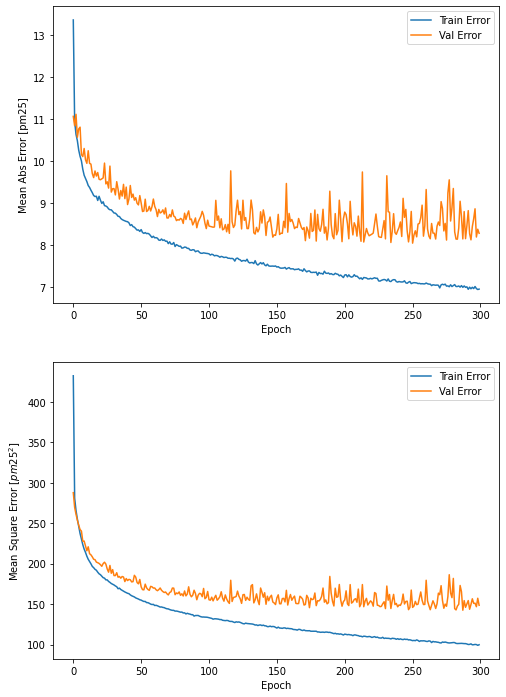

In [106]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [pm25]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  # plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$pm25^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  # plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

모델에 test data를 넣어 분포도로 결과를 확인한다.<br>
보통 오른쪽 대각선이 나와야 잘 나온것이다.

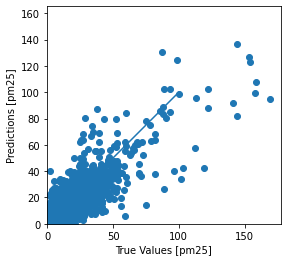

In [107]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [pm25]')
plt.ylabel('Predictions [pm25]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

오차분포를 확인한다.

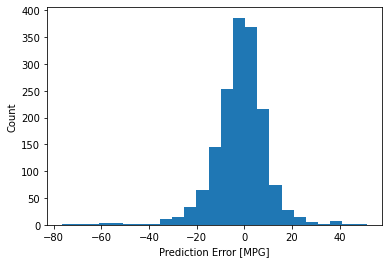

In [108]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")